### Setup

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import pygame

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from parking_simulation import parkingSim

# env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
env = parkingSim()

In [3]:
env.get_action_sample()

0

In [4]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [5]:
device = torch.device("mps")

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Deep Neural Network Setup

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, 128)
        self.layer6 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.no_of_actions
# Get the number of state observations
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state): # To select the action based on exponential decay to stabilize for initial warmup.
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or steps_done > 3000:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.get_action_sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    # plt.pause(0.00001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

2023-10-26 19:11:29.057 Python[13666:7028180] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [10]:
def is_learning_achieved(): # To cutoff learning if last 50 steps are of entire possible length of an episode.
    if len(episode_durations) < 50:
        return False
    if np.mean(episode_durations[-50:]) >= env.length - 0.01:
        return True
    return False

### Training Loop

In [11]:
full_episodes = []
if torch.has_mps:
    num_episodes = 1000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print(i_episode,end="\r")
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if truncated:
            full_episodes.append(i_episode)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # episode_durations.append(t + 1)
            # plot_durations()
            break
        
print('Complete')
env.onDestroy()
# plot_durations(show_result=True)
# plt.ioff()
# plt.show()

Complete


In [12]:
print(full_episodes)

[25, 30, 48, 51, 60, 64, 80, 84, 101, 104, 108, 112, 118, 136, 138, 160, 161, 165, 177, 189, 200, 204, 205, 213, 215, 221, 228, 230, 237, 243, 252, 261, 268, 271, 277, 280, 289, 299, 304, 305, 308, 312, 315, 321, 322, 330, 333, 338, 342, 350, 360, 367, 368, 377, 386, 388, 412, 413, 418, 425, 430, 439, 448, 458, 462, 468, 469, 483, 494, 507, 511, 512, 513, 529, 530, 532, 535, 542, 556, 558, 559, 569, 570, 581, 583, 586, 589, 594, 596, 609, 619, 623, 629, 631, 638, 639, 648, 649, 652, 653, 655, 668, 672, 675, 681, 686, 709, 710, 717, 721, 725, 731, 734, 738, 744, 745, 751, 763, 767, 792, 795, 799, 805, 812, 814, 819, 829, 842, 844, 846, 852, 854, 855, 861, 863, 866, 868, 869, 870, 896, 899, 903, 907, 910, 911, 914, 918, 919, 921, 923, 927, 928, 930, 935, 939, 940, 943, 944, 945, 956, 957, 963, 965, 966, 970, 971, 973, 979, 980, 988, 990, 992, 997]


In [13]:
len(full_episodes) / 1000 * 100

17.299999999999997

In [14]:
import pandas as pd

array([[<Axes: title={'center': 'Complete Episodes'}>]], dtype=object)

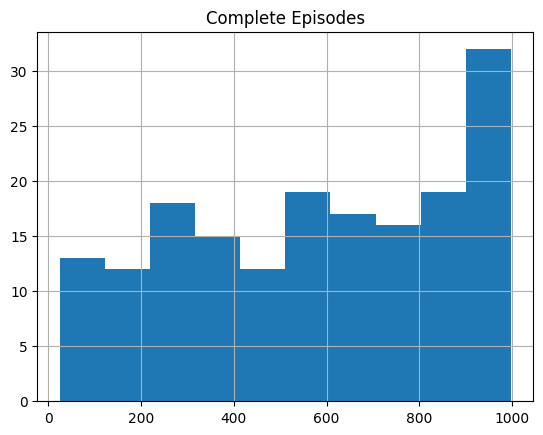

In [15]:
df = pd.DataFrame(full_episodes,columns=['Complete Episodes'])
df.hist()

### Testing

In [16]:
test_episodes_completed = []
for j in range(500):
    sn = parkingSim()
    state = sn.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print(j,end = "\r")
    for i in range(0,1000):
        action = select_action(state=state)
        obs,reward,term,trunc = sn.step(action.item())
        # print("Index:",i,"Action:",action,"Obs:",obs,"Reward:",reward,"Term:",term * 1,"Trunc:",trunc * 1,"State:",state)
        state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        if trunc:
            test_episodes_completed.append(j)
        if term or trunc:
            break

In [17]:
print(test_episodes_completed)

[4, 9, 11, 15, 25, 27, 43, 50, 60, 68, 78, 80, 88, 94, 102, 103, 107, 110, 111, 115, 116, 123, 124, 125, 126, 127, 130, 139, 145, 150, 159, 167, 169, 171, 173, 174, 178, 185, 189, 193, 195, 197, 202, 208, 209, 213, 235, 237, 248, 255, 256, 261, 264, 266, 283, 284, 289, 295, 302, 307, 308, 310, 311, 316, 326, 329, 331, 344, 345, 346, 349, 354, 359, 360, 362, 363, 364, 365, 377, 384, 388, 393, 395, 401, 406, 409, 410, 411, 417, 418, 422, 427, 429, 431, 432, 436, 437, 439, 449, 451, 455, 456, 458, 467, 468, 472, 475, 482, 489, 490, 493, 499]


In [18]:
len(test_episodes_completed) / 500 * 100

22.400000000000002

: 